In [ ]:

from google.colab import drive
!pip install keras-facenet
import os
import random
import numpy as np
import tensorflow as tf
from keras_facenet import FaceNet
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from scipy.spatial.distance import cosine
import pickle


refs : https://digitalcommons.montclair.edu/cgi/viewcontent.cgi?article=1729&context=etd. https://www.researchgate.net/profile/Sameerchand_Pudaruth2/publication/353682085_Is_Face_Recognition_with_Masks_Possible/links/61600f9d1eb5da761e5f2819/Is-Face-Recognition-with-Masks-Possible.pdf. https://www.mdpi.com/2079-9292/10/21/2666. https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6126415

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Caminho para o dataset
data_dir = '/content/drive/MyDrive/post-processed'

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from keras.layers import Input, Conv2D, BatchNormalization, GlobalMaxPooling2D, Rescaling
from keras.models import Model
from matplotlib import pyplot as plt
!pip install tensorflow_similarity
import tensorflow_similarity as tfsim



In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from keras.layers import Input, Conv2D, BatchNormalization, GlobalMaxPooling2D, Rescaling
from keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

# Parâmetros
examples_per_class_per_batch = 4
embedding_size = 256


# Função para obter classes e suas imagens
def get_class_data(data_dir):
    class_names = os.listdir(data_dir)
    class_data = {}
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('jpg', 'jpeg', 'png'))]
            class_data[class_name] = images
    return class_data

class_data = get_class_data(data_dir)


# Gerador de dados para treinamento
class TripletGenerator(tf.keras.utils.Sequence):
    def __init__(self, class_data, batch_size):
        self.class_data = class_data
        self.batch_size = batch_size
        self.class_names = list(class_data.keys())
        self.datagen = ImageDataGenerator(
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

    def __len__(self):
        return int(np.floor(len(self.class_names) * self.batch_size))

    def __getitem__(self, index):
        anchors = []
        positives = []
        negatives = []

        for _ in range(self.batch_size):
            class_name = random.choice(self.class_names)
            images = self.class_data[class_name]

            # Escolher a âncora e o positivo da mesma classe
            if len(images) < 2:
                continue
            anchor_img = random.choice(images)
            positive_img = random.choice([img for img in images if img != anchor_img])


            negative_class = random.choice([cls for cls in self.class_names if cls != class_name])
            negative_img = random.choice(self.class_data[negative_class])

            anchors.append(anchor_img)
            positives.append(positive_img)
            negatives.append(negative_img)

        # Carregar e processar as imagens
        anchor_images = np.array([tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=(32, 32))) for img in anchors])
        positive_images = np.array([tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=(32, 32))) for img in positives])
        negative_images = np.array([tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=(32, 32))) for img in negatives])

        # Normalizar os valores dos pixels
        anchor_images = anchor_images / 255.0
        positive_images = positive_images / 255.0
        negative_images = negative_images / 255.0

        # Retornar as imagens como uma tupla
        X = (anchor_images, positive_images, negative_images)
        y_true = np.zeros((self.batch_size, 1))

        return X, y_true


triplet_generator = TripletGenerator(class_data, batch_size=examples_per_class_per_batch)
val_triplet_generator = TripletGenerator(class_data, batch_size=examples_per_class_per_batch)  

inputs = Input(shape=(32, 32, 3))

anchor_input = Input(shape=(32, 32, 3), name='anchor_input')
positive_input = Input(shape=(32, 32, 3), name='positive_input')
negative_input = Input(shape=(32, 32, 3), name='negative_input')


def create_embedding(input_tensor):
    x = Rescaling(scale=1.0 / 255)(input_tensor)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = GlobalMaxPooling2D()(x)


    outputs = tf.keras.layers.Dense(embedding_size, activation='linear')(x)
    return outputs


anchor_embedding = create_embedding(anchor_input)
positive_embedding = create_embedding(positive_input)
negative_embedding = create_embedding(negative_input)


merged_output = tf.keras.layers.concatenate([anchor_embedding, positive_embedding, negative_embedding], axis=-1)

model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged_output)

def triplet_loss(y_true, y_pred):
    anchor, positive, negative = tf.split(y_pred, num_or_size_splits=3, axis=1)

    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)

    basic_loss = pos_dist - neg_dist + 0.2  # alpha = 0.2
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0))
    return loss

model.compile(optimizer=tf.keras.optimizers.Adam(0.002), loss=triplet_loss)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Treinamento do modelo com batches manualmente
for epoch in range(80):  
    print(f"Epoch {epoch + 1}/80")

    (anchor_images, positive_images, negative_images), _ = triplet_generator[0]
    loss = model.train_on_batch([anchor_images, positive_images, negative_images], np.zeros((examples_per_class_per_batch, 1)))
    print(f"Training Loss: {loss}")
    (val_anchor_images, val_positive_images, val_negative_images), _ = val_triplet_generator[0]
    val_loss = model.test_on_batch([val_anchor_images, val_positive_images, val_negative_images], np.zeros((examples_per_class_per_batch, 1)))

    print(f"Validation Loss: {val_loss}")

Epoch 1/80
Training Loss: 86.00625610351562
Validation Loss: 43.09599685668945
Epoch 2/80
Training Loss: 28.73066520690918
Validation Loss: 21.58889389038086
Epoch 3/80
Training Loss: 17.271114349365234
Validation Loss: 14.415263175964355
Epoch 4/80
Training Loss: 12.355939865112305
Validation Loss: 10.823795318603516
Epoch 5/80
Training Loss: 9.756660461425781
Validation Loss: 8.773783683776855
Epoch 6/80
Training Loss: 7.966999053955078
Validation Loss: 7.296093940734863
Epoch 7/80
Training Loss: 6.729406833648682
Validation Loss: 6.2444047927856445
Epoch 8/80
Training Loss: 5.824612617492676
Validation Loss: 5.45770788192749
Epoch 9/80
Training Loss: 5.134288311004639
Validation Loss: 4.847055435180664
Epoch 10/80
Training Loss: 4.59025764465332
Validation Loss: 4.3593010902404785
Epoch 11/80
Training Loss: 4.150472640991211
Validation Loss: 3.9607365131378174
Epoch 12/80
Training Loss: 3.7875895500183105
Validation Loss: 3.6289472579956055
Epoch 13/80
Training Loss: 3.4830598831176

In [ ]:
# Função para gerar e armazenar embeddings das celebridades
def create_embedding_database(class_data, model):
    embedding_database = {}

    for class_name, images in class_data.items():
        embeddings = []
        for img in images:
            img_array = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=(32, 32)))
            img_array = np.expand_dims(img_array, axis=0) / 255.0

            dummy_input = np.zeros_like(img_array)

            embedding = model.predict([img_array, dummy_input, dummy_input])
            embedding = embedding[:, :embedding_size]

            embeddings.append(embedding)
        embedding_database[class_name] = np.array(embeddings)

    return embedding_database

# Criar o banco de dados de embeddings
embedding_database = create_embedding_database(class_data, model)

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/s

In [ ]:
import pickle

def save_embedding_database_to_pickle(embedding_database, filename):
    drive_path = f'/content/drive/My Drive/{filename}'
    with open(drive_path, 'wb') as f:
        pickle.dump(embedding_database, f)

# Salvar o banco de dados de embeddings
save_embedding_database_to_pickle(embedding_database, 'embedding_database.pkl')

In [ ]:
def load_embedding_database_from_pickle(filename):
    drive_path = f'/content/drive/My Drive/{filename}'
    with open(drive_path, 'rb') as f:
        embedding_database = pickle.load(f)
    return embedding_database

# Carregar o banco de dados de embeddings
embedding_database = load_embedding_database_from_pickle('embedding_database.pkl')


In [ ]:
# Função para adicionar uma nova pessoa ao banco de dados

def add_person_to_database(image_path, class_name, model, embedding_database, embedding_size=256):
    img_array = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(image_path, target_size=(32, 32)))
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    dummy_input = np.zeros_like(img_array)

    embedding = model.predict([img_array, dummy_input, dummy_input])
    embedding = embedding[:, :embedding_size]

    if class_name in embedding_database:
        embedding_database[class_name] = np.append(embedding_database[class_name], [embedding], axis=0)
    else:
        embedding_database[class_name] = np.array([embedding])

# Altere o caminho da imagem e o nome da classe conforme necessário
add_person_to_database('/content/drive/My Drive/marcelinho_no_db.jpg', 'Marcelinho', model, embedding_database)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


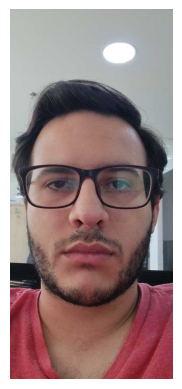

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def plot_image(image_path):
    img = load_img(image_path) 
    plt.imshow(img)  
    plt.axis('off')  
    plt.show()

# Exemplo de uso para exibir a imagem
image_path = '/content/drive/My Drive/marcelinho_no_db.jpg'
plot_image(image_path)

In [ ]:
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import img_to_array, load_img
threshold = 0.9


def get_embedding_from_image(image_path, model):
    img_array = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(image_path, target_size=(32, 32)))
    img_array = np.expand_dims(img_array, axis=0) / 255.0  #
    dummy_input = np.zeros_like(img_array)
    embedding = model.predict([img_array, dummy_input, dummy_input])
    embedding = embedding[:, :256]

    return embedding

def recognize_person(embedding, embedding_database, similarity_threshold=0.8):
    closest_person = None
    highest_similarity = 0

    # Itera sobre o banco de dados para encontrar o embedding mais próximo
    for class_name, class_embeddings in embedding_database.items():
        for stored_embedding in class_embeddings:
            distance = np.linalg.norm(embedding - stored_embedding)
            similarity = 1 - distance
            if similarity > highest_similarity:
                highest_similarity = similarity
                closest_person = class_name

    if highest_similarity >= similarity_threshold:
        certainty = highest_similarity * 100
        return closest_person, certainty
    else:
        return "Unknown", 0


def check_similarity_with_specific_person(embedding, embedding_database, target_person, similarity_threshold=0.80):
    highest_similarity = 0
    if target_person in embedding_database:
        target_embeddings = embedding_database[target_person]
        for stored_embedding in target_embeddings:
            distance = np.linalg.norm(embedding - stored_embedding)
            similarity = 1 - distance

            # Verifica se a similaridade é maior que a similaridade mais alta encontrada
            if similarity > highest_similarity:
                highest_similarity = similarity


        if highest_similarity >= similarity_threshold:
            certainty = highest_similarity * 100
            return True, certainty
        else:
            return False, highest_similarity * 100
    else:
        return False, 0


new_image_path = '/content/drive/My Drive/marcelinho_na_inferencia.jpg'  # Caminho da nova imagem
new_embedding = get_embedding_from_image(new_image_path, model)
recognized_person, certainty = recognize_person(new_embedding, embedding_database)


print(f'A nova imagem é reconhecida como: {recognized_person} com {certainty}% de certeza.')

is_marcelinho, certainty = check_similarity_with_specific_person(new_embedding, embedding_database, "Marcelinho")
if is_marcelinho:
    print(f'A nova imagem é do Marcelinho com {certainty:.2f}% de certeza.')
else:
    print(f'A nova imagem não é do Marcelinho (similaridade: {certainty:.2f}%).')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
A nova imagem é reconhecida como: Marcelinho com 88.45830783247948% de certeza.
A nova imagem é do Marcelinho com 88.46% de certeza.


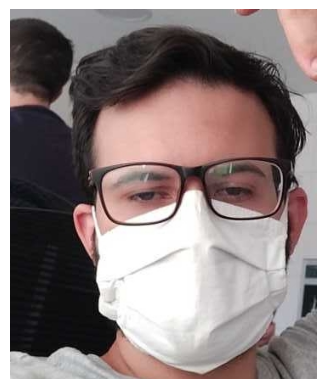

In [ ]:
image_path = '/content/drive/My Drive/marcelinho_na_inferencia.jpg'
plot_image(image_path)